In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# theme = Distribution plot of locomotion sensors values for each cow
# tools = Python, Numpy, Pandas, Matplotlib
# author = Dylan Lebatteux

In [56]:
###############
### Imports ###
###############
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt

In [57]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [58]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("Locomotion")

# Initialize the data dictionary
data = {}
# Get the list of sensor names
sensor_names = pd.read_excel("Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("Locomotion/" + locomotion)
      df = df.dropna(how = "all")
      #df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [59]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
# Set the number of rows for all arrays with he minimal value
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 502


In [60]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    matrix = []
    for i in range(n_columns):
      sequence = []
      for j in range(n_rows):
        try: sequence.append(float(value[j][i]))
        except:sequence.append(np.nan)
      sequence = np.array(sequence)
      matrix.append(sequence)
    matrix = np.array(matrix)
    X.append(matrix)

    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Transform the matrix avec vector to numpy array
X = np.array(X)
y = np.array(y)

In [63]:
##########################################
### Perform data augmentation by value ###
##########################################

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variables
median_filter = False
variation_percentage = 5
data_augmentation_by_value = True

# Iterate through the instances of X
for i, x in enumerate(X):
    # Initialize the vector to save the new matrix
    x_Generated = []
    # Iterate through the row of the actual instance
    for row in x:
        # Initialize the vector to save the new row
        x_Generated_Row = []
        # Perform data augmentation by feature
        if data_augmentation_by_value == False: 
            # Generate random variation for the instance
            random_number = random.random()  * variation_percentage / 100
            # Generate boolen to add or remove the variation
            boolean = random.randint(0 , 1)
        # Iterate through the value of the actual row
        for value in row:
            if value !=  0:
                # Perform data augmentation by value
                if data_augmentation_by_value == True: 
                    # Generate random variation for the instance
                    random_number = random.random()  * variation_percentage / 100
                    # Generate boolen to add or remove the variation
                    boolean = random.randint(0 , 1)
                # Save value adding variation
                if boolean == 0: x_Generated_Row.append(value + value * random_number)
                # Save value removing variation
                else: x_Generated_Row.append(value - value * random_number)
            else: x_Generated_Row.append(np.nan)
        # Convert the row vector to numpy array
        x_Generated_Row = np.array(x_Generated_Row)
        # Save the row vector
        x_Generated.append(x_Generated_Row)
    # Apply median filter
    if median_filter == True: x_Generated = medfilt(x_Generated)
    # Convert the matrix vector to numpy matrix
    x_Generated = np.array(x_Generated)
    # Save the generated matrix
    X_Generated.append(x_Generated)
    # Save the associated classes
    y_Generated.append(y[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

In [64]:
#################################
### Fonction to generate plot ###
#################################

# Define the function
def generatePlot(id_feature, X, y):
  # Index of the subplot
  n = 1
  # Set the size of the figure
  plt.figure(figsize=[30, 40])
  # Set title of the figure
  title = "Distribution of sensor (" + sensor_names [id_feature] + ") values for each cow"
  # Format the title of the figure
  plt.suptitle(title,  x=0.5, y=1.025,fontsize=19, fontweight='bold')
  # Set the postion of the subplots
  plt.subplots_adjust(left = 0.10, right = 0.90, top = 1.0, bottom= 0.25, wspace = 0.3, hspace = 0.8)
  # Iterate through the data dictionary
  for index, value in enumerate(X):
    # If belongs to the interest classes
    if y[index] == 0 or y[index] == 1 or y[index] == 2 or y[index] == 3:
      # Initialize the list of value for the plot
      x_plt = []
      # Iterate through the row
      for i in range(n_rows):
          # If value save the i value of the actual feature
          try:  x_plt.append(float(value[id_feature][i]))
          # Else save nan value 
          except:x_plt.append(np.nan) 
      # Set the postion of the actual subplot
      plt.subplot(19, 5, n)
      # Set the title of the actual subplot
      plt.title("Id: " + str(key) + " Class: (" + str(y[index]) + ")")
      # Set the graphical features of the plot according to the class of the actual instance
      if y[index] == 0: plt.plot(x_plt, 'r', linewidth = 2)
      if y[index] == 1: plt.plot(x_plt, 'b', linewidth = 2)
      if y[index] == 2: plt.plot(x_plt, 'g', linewidth = 2)
      if y[index] == 3: plt.plot(x_plt, 'y', linewidth = 2)
      # Increment the subplot index
      n = n +1
  # Plot the figure
  plt.show()

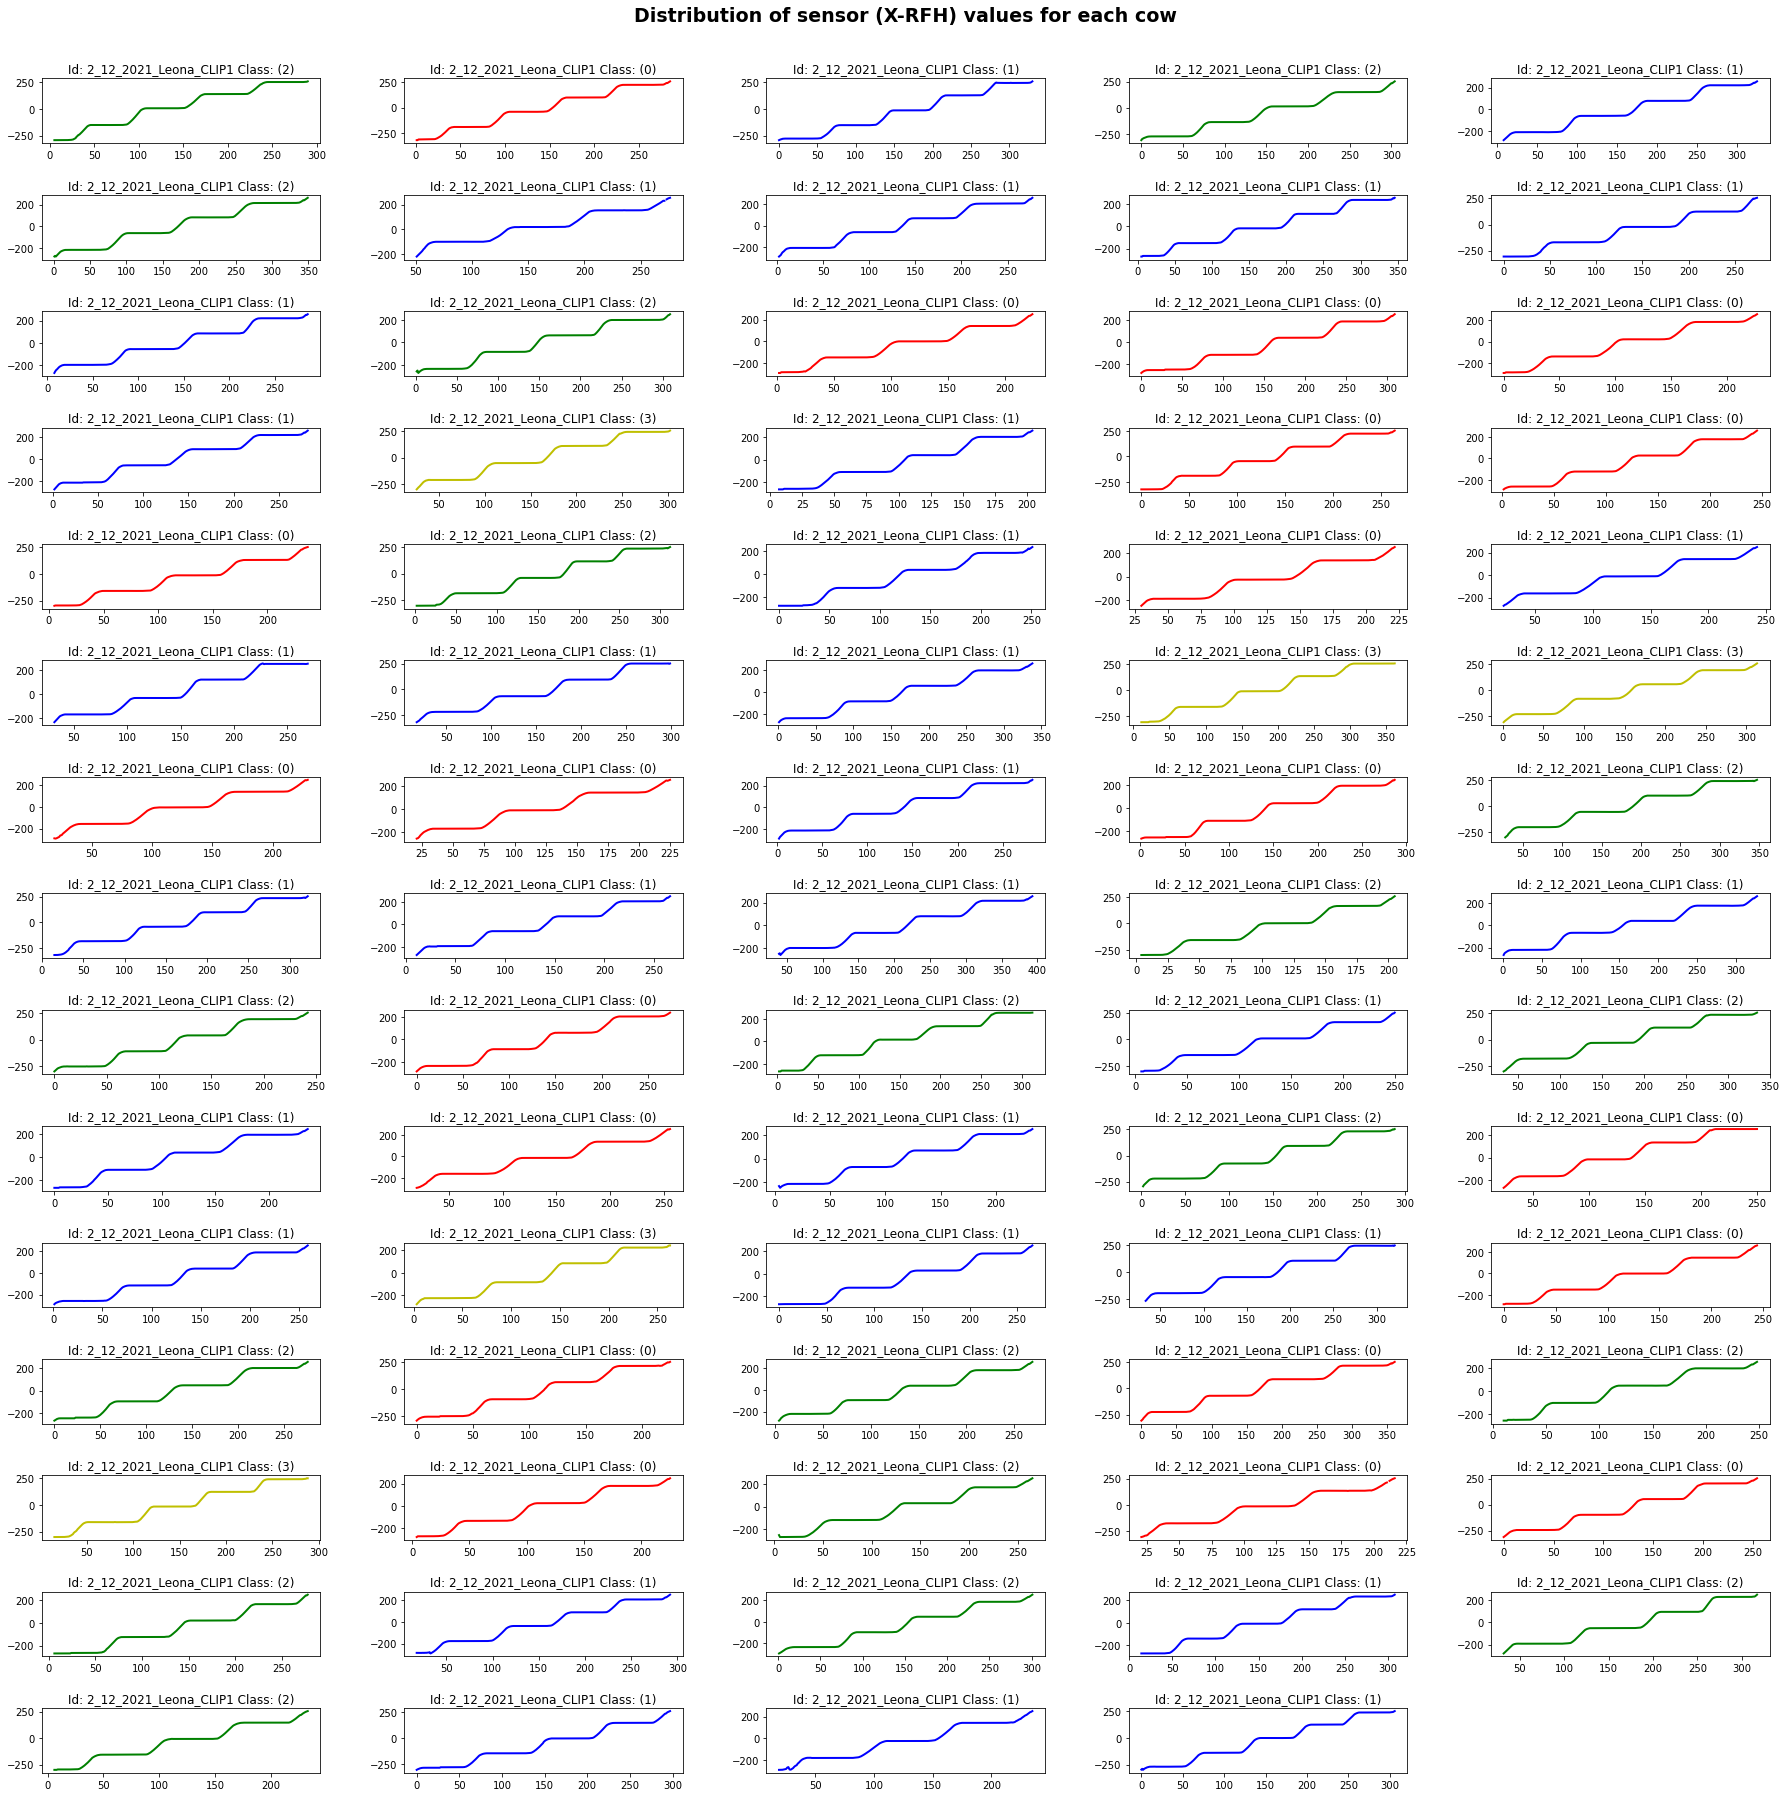

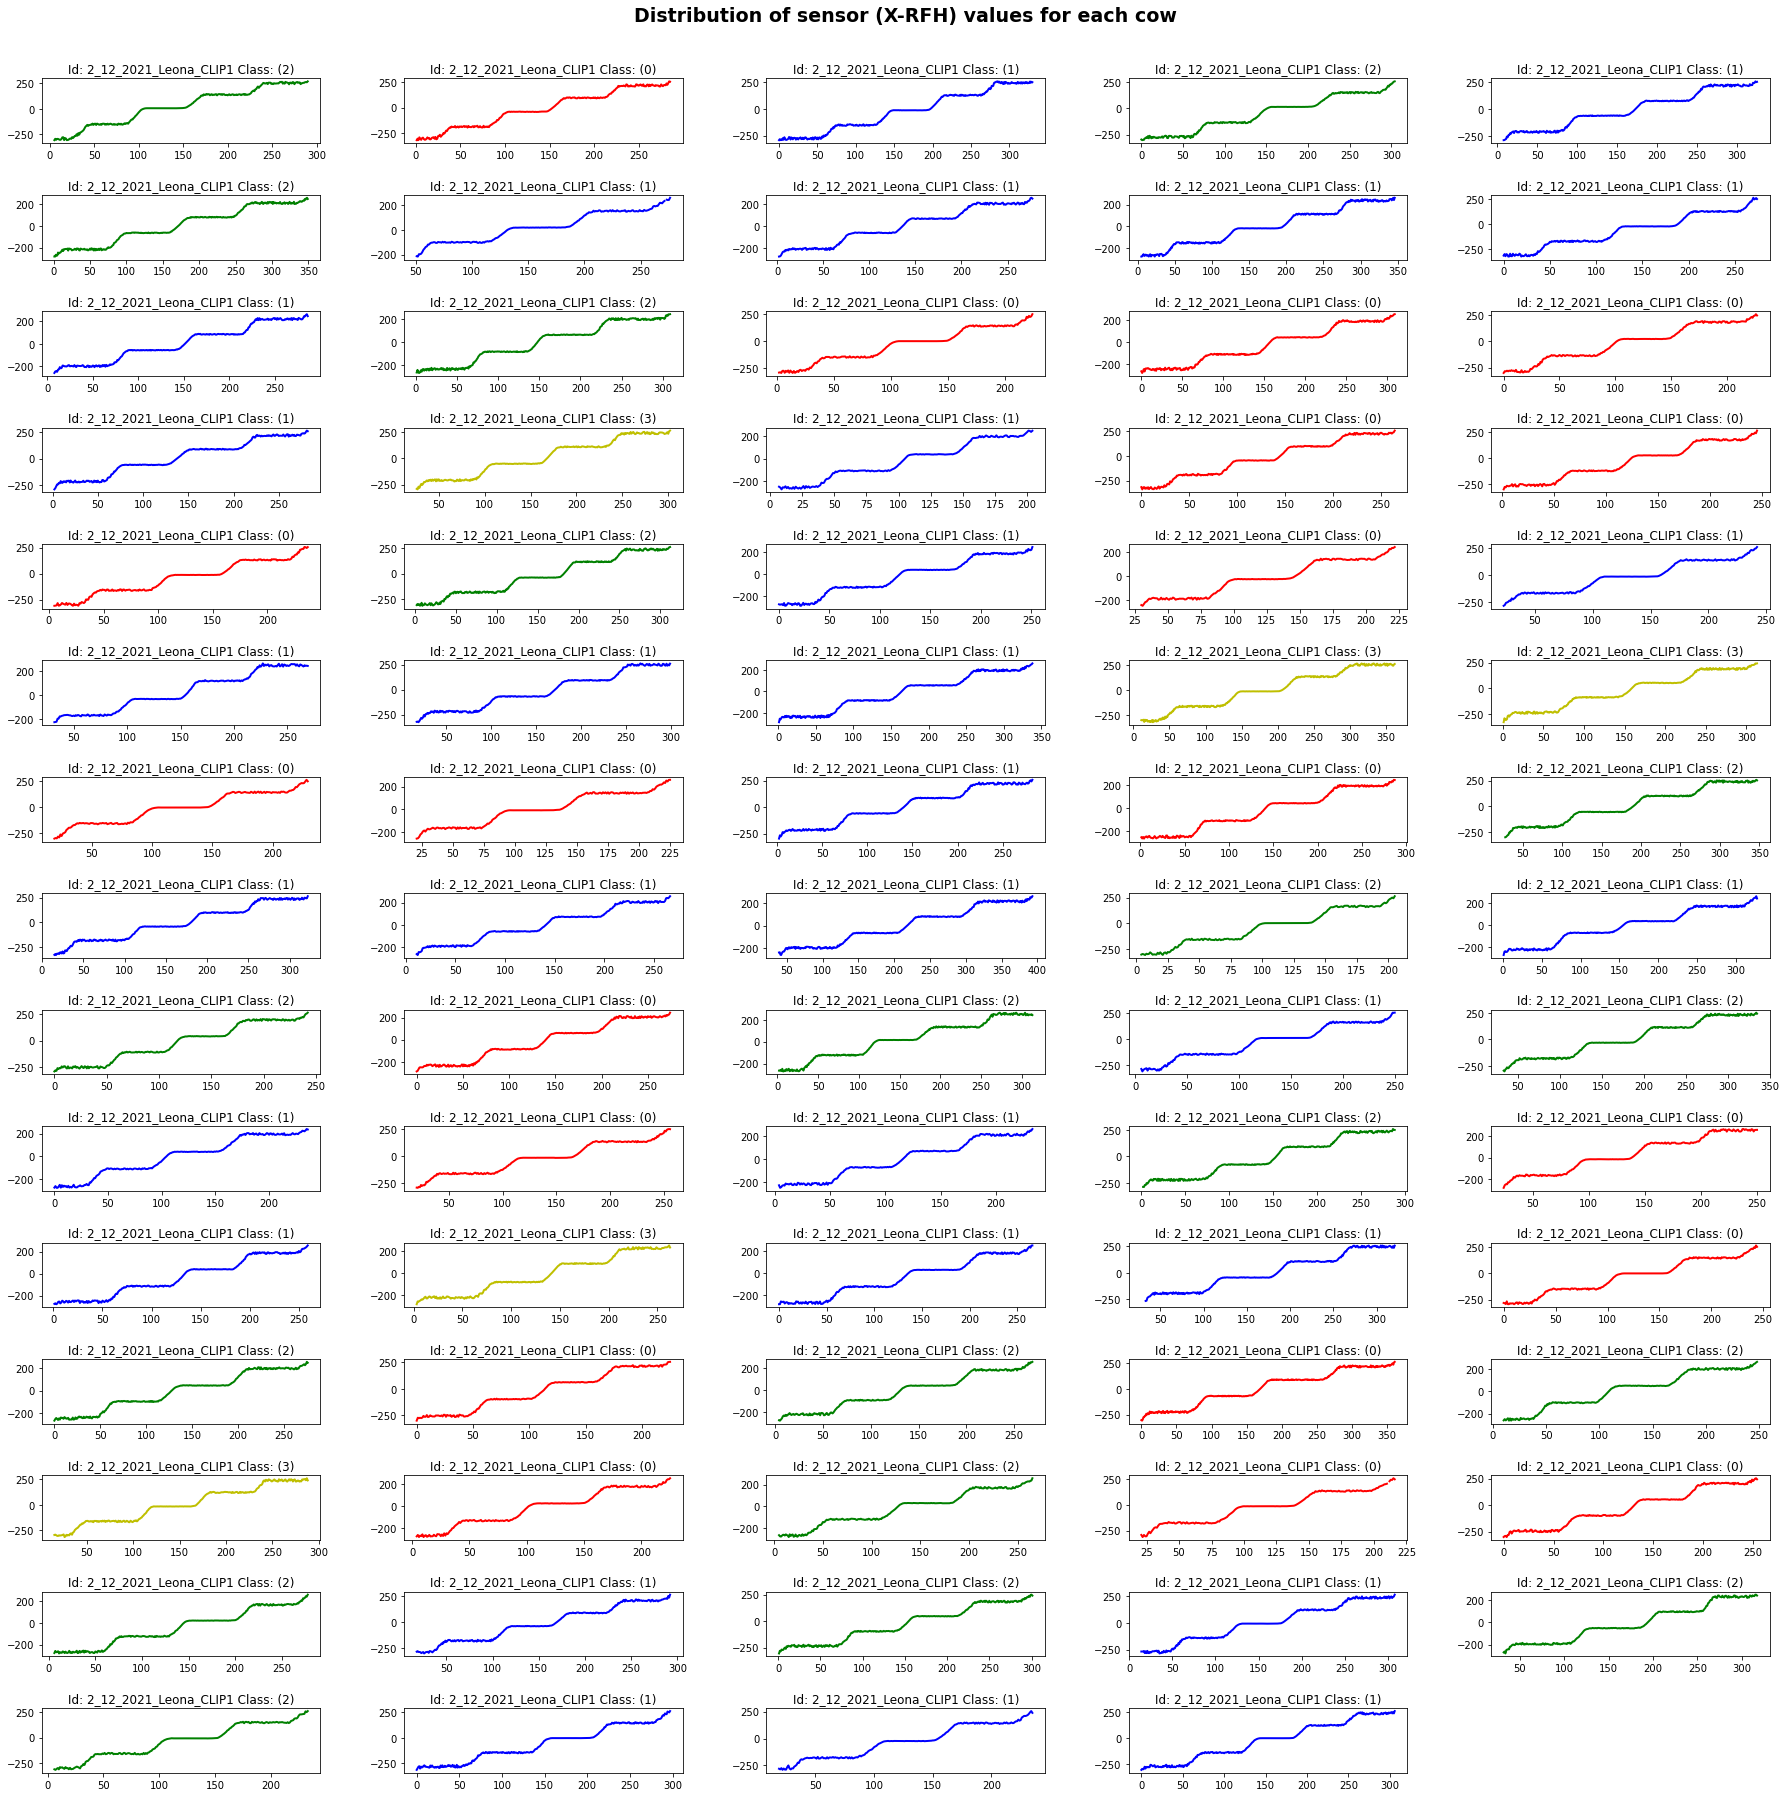

In [66]:
# Comparison of plots between original and generated data for sensor 1.
generatePlot(0, X, y)
generatePlot(0, X_Generated, y_Generated)